# Molecular optimization with hierarchical coarse-grained models

In this tutorial, we will perform a simple molecular optimization using hierarchical coarse-graining with Bayesian optimization. The goal is to efficiently identify a small molecule that shows a strong *preference* for residing in an oil-water mixture rather than in pure water or pure oil. This preference is quantified using a free energy difference, known as the "transfer free energy." Thus, our optimization target is to maximize this transfer free energy.

While this target system is relatively simple, and basic chemical intuition might suggest what kind of molecules we expect from the optimization, the same methodology can be applied to more complex systems where no prior knowledge about relevant molecular candidates is available. To keep the tutorial accessible, we introduce further simplifications, such as limiting the size of small molecules to 10 heavy atoms. Nonetheless, the procedure presented here illustrates the general principles behind the optimization strategy.

The tutorial is based on the arXiv paper [Navigating Chemical Space: Multi-Level Bayesian Optimization with Hierarchical Coarse-Graining](https://doi.org/10.48550/arXiv.2505.04169).

### **Overview**
The following list outlines the structure and time allocation for each section of the tutorial. Parts 4 and 5 contain a machine learning component, while Parts 1 through 3 introduce preliminaries related to coarse-graining and molecular dynamics simulations.
1. Coarse-graining approach *(3 min)*
2. Simulations of the target system *(8 min)*
3. Molecule enumeration *(8 min)*
4. Latent-space encoding *(10 min)*
5. Molecular optimization *(16 min)*


The following code imports all required libraries and checks the version of the molecular dynamics simulation program GROMACS:

In [ ]:
# @title
from typing import Optional
import os
import warnings
from pathlib import Path
from subprocess import run
from itertools import combinations_with_replacement
import numpy as np
import pandas as pd

""" Load libraries for visualizations """
import matplotlib.pyplot as plt

""" Load machine learning libraries """
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.nn.functional import one_hot, cross_entropy, softmax
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

""" Install and load rdkit """
from rdkit import Chem
from rdkit.Chem import Recap,BRICS

""" Install, load, and silence the alchemlyb for MBAR free energy calculations """
import logging
logging.getLogger("pymbar").setLevel(logging.ERROR)
from alchemlyb.estimators import MBAR
from alchemlyb.parsing.gmx import extract_u_nk

In [ ]:
""" Check for nvcc """

try:
    print(f'The $CUDA_HOME environment variable is set to {os.environ["CUDA_HOME"]}.')
except KeyError:
    os.environ['CUDA_HOME'] = '/usr/local/cuda'
    print(f'Set $CUDA_HOME to {os.environ["CUDA_HOME"]}.')

if f'{os.environ['CUDA_HOME']}/bin' in os.environ['PATH'].split(':'):
    print('Found $CUDA_HOME/bin in $PATH.')
else:
    os.environ['PATH'] += f':{os.environ['CUDA_HOME']}/bin'
    print('Added $CUDA_HOME/bin to $PATH.')

if f'{os.environ['CUDA_HOME']}/lib64' in os.environ['LD_LIBRARY_PATH'].split(':'):
    print('Found $CUDA_HOME/lib64 in $LD_LIBRARY_PATH.')
else:
    os.environ['LD_LIBRARY_PATH'] += f':{os.environ['CUDA_HOME']}/lib64'
    print('Added $CUDA_HOME/lib64 to $LD_LIBRARY_PATH.')

nv = !nvcc --help

if 'command not found' in nv[0]:
    print('\nCould not find nvcc. Something went wrong... Is the Cuda Toolkit installed?')
else:
    print('\nFound nvcc! You may proceed with the tutorial.')

In [ ]:
""" Download an unofficial precompiled GROMACS version and add it to the PATH """
!wget -q https://www.thphys.uni-heidelberg.de/~walter/gromacs-2024.4.zip
!unzip -q -o gromacs-2024.4.zip
!rm gromacs-2024.4.zip
os.environ['PATH'] += ':/content/gromacs-2024.4/bin'
!gmx -version | grep -Ei '(gpu support|gromacs version)'

## Coarse-graining approach

Although typically used to speed up simulations, we want to use coarse-graining to reduce the complexity of chemical space. The following image illustrates the coarse-graining process for the molecule Lutein ([Source](https://doi.org/10.3390/ijms25147947)) based on the coarse-grained (CG) force field [*Martini3*](https://doi.org/10.1038/s41592-021-01098-3), which maps two to four heavy atoms to a single CG bead:

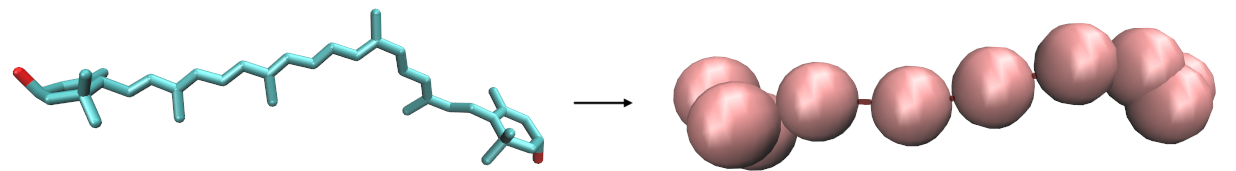

The interactions between the CG beads are determined by their bead types, which are assigned based on the underlying chemical fragments. *Martini3* employs a fixed set of bead types that can be reused across a wide range of molecules, making it a **transferable** CG force field.

Coarse-graining inherently reduces molecular detail, meaning that multiple atomistic structures can map to the same CG representation. We exploit this many-to-one relationship to reduce the complexity of the chemical search space.

The following simulations and molecular optimization procedure are based on the Martini3 force field.



## Simulations of the target system

We first have a look at our target system: A mixture of hexane and water. Hexane is an alkane with six carbons and a relatively apolar solvent. In the CG representation, water and hexane are modeled with one and two beads, respectively. To better understand the system, we run a short simulation using the MD simulation program [GROMACS](https://www.gromacs.org):

<details>

<summary>Toggle to see an explanation of the following simulation commands</summary>

* `gmx grompp` is the command to prepare a GROMACS simulation
* `-f equilibration.mdp` provides a file with all the simulation parameters (see [here](https://manual.gromacs.org/current/user-guide/mdp-options.html) for further details)
* `-c mixture.gro` provides a file with the initial structure
* `-p mixture.top` provides a topology file that describes bonded and non-bonded interactions between atoms or beads
* `-o mixture/simulation.tpr` path for the output of the simulation file
* `gmx mdrun -deffnm mixture/simulation` runs the simulation for the provided simulation file

</details>

In [ ]:
!mkdir -p mixture
!gmx grompp -f equilibration.mdp -c mixture.gro -p mixture.top -o mixture/simulation.tpr
!gmx mdrun -deffnm mixture/simulation

In [ ]:
nglview MDAnalysis

In [ ]:
!pip install --force-reinstall notebook==7.4.3

In [ ]:
import MDAnalysis as mda
import nglview as nv

# Load your .gro (structure) and .xtc (trajectory) files
u = mda.Universe("mixture/simulation.gro", "mixture/simulation.xtc")

# Visualize with nglview
view = nv.show_mdanalysis(u)
view.add_representation('cartoon')  # good for proteins
view.add_representation('licorice', selection='not protein')  # show non-protein atoms
view.center()
view

The output provides information about the simulation run, for example, about the usage of the GPUs and CPU threads and the simulation performance.

Let's now visualize the simulation:

## Molecule enumeration

The *Martini3* force field contains more than 800 different bead types. If we consider the combinatorial complexity arising from these, we still get a large number of possible CG molecule. To obtain a further simplified representation of chemical space we can reduce the bead-type resolution and obtain a low-resolution CG force field. The *Martini3* force field, for example, contains 72 bead types to represent apolar fragments. While the variety of apolar bead types allows to accuratly represent atomistic structures it also introduces a singificant complexity. Using, for example, only a single bead type to represent all apolar fragments, removes chemical detail but also reduces the complexity a lot. Our goal is to combine diffrent levels of coarse-graining into one optimization to get a chemically detailed result but an efficient optimization process.

We use two different levels of coarse-graining resolutions:
1. **High resolution**: 22 bead types from the *Martini3* force field.
2. **Low resolution**: 4 bead types, derived from averaged bead interactions of *Martini3* bead types

In [ ]:
class Molecule:
  bead_types = None

  @classmethod
  def enumerate_all(cls):
    beads = combinations_with_replacement(cls.bead_types, 2)
    return [cls(b) for b in beads]

  def __init__(self, beads):
    self.beads = sorted(beads)
    self.encoding = None
  def __repr__(self) -> str:
    return '-'.join(self.beads)
  def __hash__(self) -> int:
    return hash(str(self))
  def __eq__(self, other) -> bool:
    return self.beads == other.beads
  @property
  def topology_beads(self):
    return self.beads

class LowResMolecule(Molecule):
  bead_types = ['K1', 'K2', 'K3', 'K4']

class HighResMolecule(Molecule):
  bead_types = [
    'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6',
    'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'X1', 'X2', 'X3', 'X4'
  ]
  bead_classes = ['C','N','P','X']
  def one_hot_representation(self):
    indices = [int(b[1])-1 for b in self.beads]
    types = [HighResMolecule.bead_classes.index(b[0]) for b in self.beads]
    indices_one_hot = one_hot(torch.LongTensor(indices), 6)
    types_one_hot = one_hot(torch.LongTensor(types), 4)
    return torch.cat((indices_one_hot,types_one_hot), dim=1).flatten().float()
  def distance(self, other):
    if self.encoding is None or other.encoding is None:
      raise ValueError("Unknown molecule encoding")
    return np.linalg.norm(self.encoding - other.encoding)
  def low_res_representation(self):
    return LowResMolecule([s[0] for s in self.beads])
  @staticmethod
  def from_autoencoder_prediction(prediction):
    i1 = softmax(prediction[:6], dim=0).argmax() + 1
    c1 = HighResMolecule.bead_classes[softmax(prediction[6:10], dim=0).argmax()]
    i2 = softmax(prediction[10:16], dim=0).argmax() + 1
    c2 = HighResMolecule.bead_classes[softmax(prediction[16:], dim=0).argmax()]
    return Molecule([f'{c1}{i1}', f'{c2}{i2}'])

In [ ]:
low_res_molecules = LowResMolecule.enumerate_all()
high_res_molecules = HighResMolecule.enumerate_all()
print(f"Number of low resolution molecules: {len(low_res_molecules)}")
print(f"Number of high resolution molecules: {len(high_res_molecules)}")

### Encode molecules

In [ ]:
class Autoencoder(nn.Module):

  def __init__(self):
    super(Autoencoder, self).__init__()
    self.embedding = nn.Sequential(
      nn.Linear(10,32), nn.ReLU(True),
      nn.Linear(32,16)
    )
    self.encoder = nn.Sequential(
      nn.Linear(32,128), nn.ReLU(True),
      nn.Linear(128,2)
    )
    self.decoder = nn.Sequential(
      nn.Linear(2,256), nn.ReLU(True),
      nn.Linear(256,128), nn.ReLU(True),
      nn.Linear(128,20)
    )
  def encode(self, x):
    embedding1 = self.embedding(x[:,:10])
    embedding2 = self.embedding(x[:,10:])
    x = torch.cat((embedding1, embedding2), dim=1)
    return self.encoder(x)
  def decode(self, x):
    return self.decoder(x)
  def forward(self, x):
    return self.decode(self.encode(x))

def invariant_reconstruction_loss(decoded, input):
    di1, dc1, di2, dc2 = decoded[:,:6], decoded[:,6:10], decoded[:,10:16], decoded[:,16:]
    ii1, ic1, ii2, ic2 = input[:,:6], input[:,6:10], input[:,10:16], input[:,16:]
    loss1 = cross_entropy(di1, ii1, reduction='none') + cross_entropy(dc1, ic1, reduction='none')
    loss1 += cross_entropy(di2, ii2, reduction='none') + cross_entropy(dc2, ic2, reduction='none')
    loss2 = cross_entropy(di1, ii2, reduction='none') + cross_entropy(dc1, ic2, reduction='none')
    loss2 += cross_entropy(di2, ii1, reduction='none') + cross_entropy(dc2, ic1, reduction='none')
    return torch.minimum(loss1, loss2).mean()

In [ ]:
mol_features = torch.stack([m.one_hot_representation() for m in high_res_molecules])
model = Autoencoder()
optimizer = torch.optim.Adam([
    {'params': model.embedding.parameters()},
    {'params': model.encoder.parameters()},
    {'params': model.decoder.parameters(), 'weight_decay': 1e-3}
  ], lr=0.001)

In [ ]:
for epoch in range(2500):
    optimizer.zero_grad()
    encoded = model.encode(mol_features)
    decoded = model.decode(encoded)
    latent_loss = 0.5 * torch.mean(encoded**2)
    recon_loss = invariant_reconstruction_loss(decoded, mol_features)
    loss = recon_loss + 0.08 * latent_loss
    loss.backward()
    optimizer.step()
print(f"Epoch {epoch+1}: Loss = {recon_loss.item()}, Latent Loss = {latent_loss.item()}")

In [ ]:
encoded = model.encode(mol_features)
decoded = model.decode(encoded)
encoded = encoded.detach().numpy()
correct_reconstructions = 0
for n in range(len(high_res_molecules)):
  recon = HighResMolecule.from_autoencoder_prediction(decoded[n])
  correct_reconstructions += int(recon == high_res_molecules[n])
  high_res_molecules[n].encoding = encoded[n].tolist()
  if n % 50 == 0:
    print(f'Input: {high_res_molecules[n]} Predicted: {recon}, Latent space: {encoded[n]}')
print(f'Exact accuracy: {correct_reconstructions / len(high_res_molecules):.3f}')
fig, axs = plt.subplots(ncols=1, figsize=(7,7))
s = axs.scatter(encoded[:,0], encoded[:,1], s=20, edgecolors='r', linewidths=1, color='none')
for n in range(len(high_res_molecules)):
  axs.annotate(str(high_res_molecules[n]), (encoded[n,0], encoded[n,1]), fontsize=7)
plt.show()

### Setup simulations

In [ ]:
def simulate_molecule(molecule):
  try:
    molecule_path = Path('simulations') / str(molecule)
    for system in ['water', 'hexane', 'mixture']:
      system_path = molecule_path / system
      if system_path.exists():
        continue
      system_path.mkdir(parents=True, exist_ok=True)
      topology = Path(f'{system}-lig.top').read_text()
      for placeholder, replacement in zip(['B1', 'B2'], molecule.topology_beads):
        topology = topology.replace(placeholder, replacement)
      Path(system_path / 'system.top').write_text(topology)
      command = (f'gmx grompp -f equilibration.mdp -c {system}-lig.gro -p {system_path}/system.top ' +
          f'-o {system_path}/equilibration.tpr -po {system_path}/equilibration.out.mdp && ' +
          f'gmx mdrun -deffnm {system_path}/equilibration')
      run(command, shell=True, check=True)
      if system == 'mixture':
        run('sed -i "s/^nsteps.*/nsteps                   = 30000/" lambda-run.mdp', shell=True, check=True)
      else:
        run('sed -i "s/^nsteps.*/nsteps                   = 20000/" lambda-run.mdp', shell=True, check=True)
      for i in range(8):
        lambda_path = system_path / f'lambda{i}'
        lambda_path.mkdir(exist_ok=True)
        run(f'sed -i "s/^init-lambda-state.*/init-lambda-state        = {i}/" lambda-run.mdp', shell=True, check=True)
        command = (f'gmx grompp -f lambda-run.mdp -c {system_path}/equilibration.gro -p {system_path}/system.top ' +
          f'-o {lambda_path}/production.tpr -po {lambda_path}/production.out.mdp && ' +
          f'gmx mdrun -deffnm {lambda_path}/production')
        run(command, shell=True, check=True)
  except Exception as e:
    print(f'Failed to simulate {molecule}, please retry')
    raise e

In [ ]:
def calculate_free_energy(molecule: Molecule, system: str):
    path = Path('simulations') / str(molecule) / system
    if not path.exists():
        raise ValueError(f"Simulations for {molecule}/{system} not found")
    xvg_files = [p / 'production.xvg' for p in path.iterdir() if p.is_dir()]
    u_nk_list = [extract_u_nk(f, T=305) for f in xvg_files]
    u_nk_combined = pd.concat(u_nk_list)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mbar = MBAR().fit(u_nk_combined)
    free_energy = float(mbar.delta_f_.iloc[0, -1]) * 0.5924  # Convert to kcal/mol
    d_free_energy = float(mbar.d_delta_f_.iloc[0, -1]) * 0.5924 # Convert to kcal/mol
    return free_energy, d_free_energy

def calculate_free_energy_difference(molecule: Molecule):
  result = {}
  for system in ['water', 'hexane', 'mixture']:
    ddg, ddg_err = calculate_free_energy(molecule, system)
    result[system] = ddg
    #print(f'{system}: {ddg:.3f} +/- {ddg_err:.3f} kcal/mol')
  return max(result['hexane'] - result['mixture'], result['water'] - result['mixture'])

In [ ]:
pre_simulated_molecule_data = {
  LowResMolecule(['C', 'P']): -0.983, LowResMolecule(['P', 'X']): -0.871,
  LowResMolecule(['N', 'X']): -0.665, LowResMolecule(['N', 'N']): -0.601,
  LowResMolecule(['C', 'N']): -0.163, LowResMolecule(['N', 'P']): 0.056,
  LowResMolecule(['C', 'X']): 0.606, LowResMolecule(['X', 'X']): 0.740,
  LowResMolecule(['C', 'C']): 1.025, LowResMolecule(['P', 'P']): 1.321,
}

### Multi-level Bayesian optimization

In [ ]:
def expected_improvement(mean_prediction, std_prediction, best_prediction, xi=0.0):
  z = (best_prediction - xi - mean_prediction)
  return z * norm.cdf(z / std_prediction) + std_prediction * norm.pdf(z / std_prediction)

In [ ]:
simulation_data = {}
low_res_prior = np.array([pre_simulated_molecule_data[m.low_res_representation()] for m in high_res_molecules])

In [ ]:
for i in range(15):
  kernel = RBF(length_scale=0.5, length_scale_bounds=(0.05, 2))
  gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.05)
  current_best = max(pre_simulated_molecule_data.values())
  if len(simulation_data) > 0:
    current_best = max(simulation_data.values())
    X = [high_res_molecules[i].encoding for i in simulation_data.keys()]
    Y = [result - low_res_prior[i] for i, result in simulation_data.items()]
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      gaussian_process.fit(X, Y)
    #print(f'Kernel lengthscale: {gaussian_process.kernel_.get_params()["length_scale"]:.3f}')
  prediction_input = [m.encoding for i, m in enumerate(high_res_molecules)]
  mean_prediction, std_prediction = gaussian_process.predict(prediction_input, return_std=True)
  mean_prediction = mean_prediction + low_res_prior
  ei = expected_improvement(mean_prediction, std_prediction, current_best)
  ei = np.ma.masked_array(ei, mask=np.isin(np.arange(len(ei)), list(simulation_data.keys())))
  next_index = np.random.choice(np.nonzero(ei == ei.max())[0])
  next_molecule = high_res_molecules[next_index]
  print(f'Simulating next molecule: {next_molecule}')
  simulate_molecule(next_molecule)
  simulation_result = calculate_free_energy_difference(next_molecule)
  print(f'Simulation result: {simulation_result:.3f}')
  simulation_data[next_index] = simulation_result

In [ ]:
for i, res in sorted(simulation_data.items(), key=lambda x: x[1])[:3]:
  print(f'{high_res_molecules[i]}: {res:.3f}')